# Diffusion Models vs. GANs  


In this notebook, we are going to implement Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

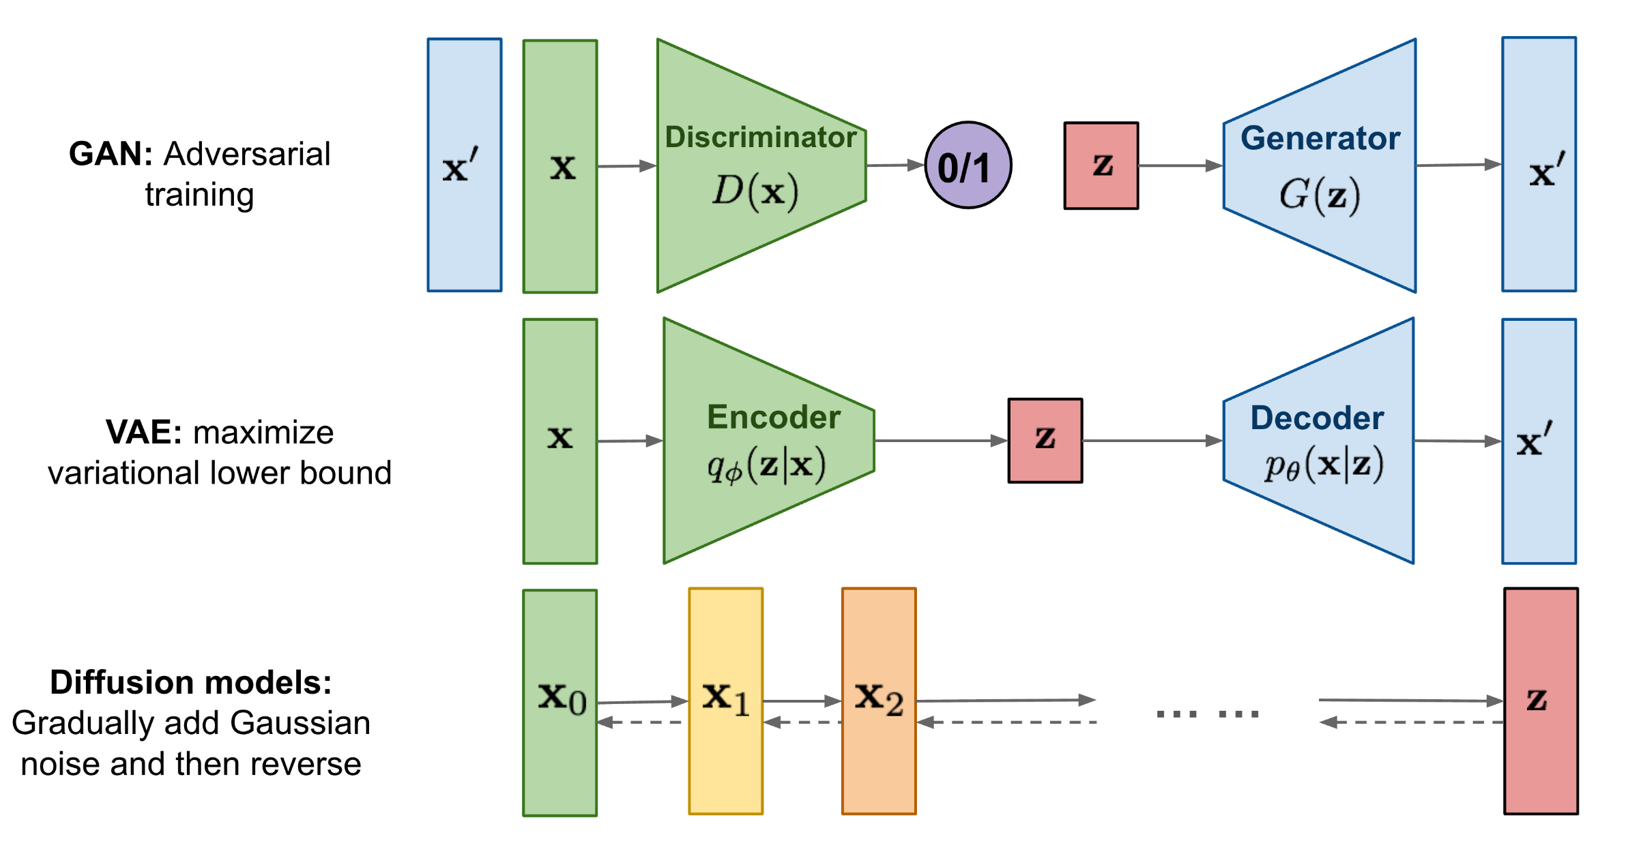

## Dataset Overview

In this notebook, we will work with the **FashionMNIST** dataset. This dataset includes:

- **Training Set**: 60,000 examples
- **Test Set**: 10,000 examples

Each sample is a **28x28 grayscale image** associated with one of **10 classes**. For the purpose of this notebook, we will focus on the training split.


In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from einops import rearrange
import json


# Constants
BATCH_SIZE = 8
IMG_SIZE = 32
C_IN = 1  # Number of input channels
LR = 2e-5
EPOCHS = 10

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
Tensor = torch.cuda.FloatTensor if DEVICE == 'cuda' else torch.FloatTensor

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.55MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



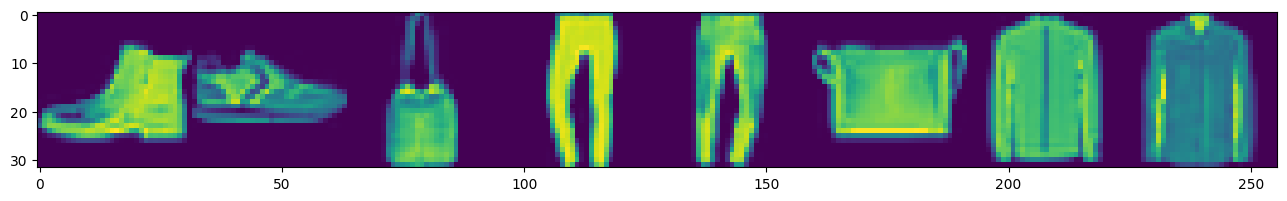

In [2]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)
    data = torchvision.datasets.FashionMNIST(root=".", download=True, train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([torch.cat([i for i in images], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## GAN

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

**NOTE:**\
One major challenge in GAN optimization is **mode collapse**, where the generator produces limited varieties of outputs, failing to capture the full diversity of the real data distribution. This occurs because the generator finds a small set of outputs that consistently fool the discriminator, leading to repetitive samples. A common approach to address this issue is using techniques like minibatch discrimination or adding noise to the discriminator’s inputs to encourage diversity.

Another significant challenge is **vanishing gradients**, which happens when the discriminator becomes too strong, perfectly classifying real and fake images. As a result, the generator receives little to no gradient updates, slowing down learning. This problem can be mitigated by techniques such as using non-saturating loss functions, feature matching, or adopting architectures like Wasserstein GAN (WGAN), which replaces the original loss with a Wasserstein distance metric to improve gradient flow.

**Training instability** is another difficulty in GANs. The adversarial nature of training often leads to oscillations where neither network converges properly. Since the generator and discriminator update their parameters in a competitive manner, improper balancing can cause one network to dominate, preventing stable training. Strategies such as spectral normalization, two-time-scale update rules (TTUR), and progressive growing of GANs have been proposed to stabilize training dynamics.

GANs also suffer from **evaluation challenges** because there is no straightforward way to measure the quality of generated samples objectively. Unlike supervised learning, where accuracy or loss provides a clear metric, GAN evaluation relies on qualitative assessments or indirect metrics such as Inception Score (IS) and Frechet Inception Distance (FID). These metrics help estimate the similarity between generated and real distributions but are still imperfect for comprehensive evaluation.

By employing these strategies, GAN training can be made more robust, ensuring that both the generator and discriminator improve effectively over time.

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.net(z)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        real_or_fake = self.net(img)
        return real_or_fake.view(-1, 1).squeeze(1)

class GANManager():
    def __init__(self, z_dim=100, img_channels=1, feature_g=64, feature_d=64, lr=2e-5, device='cpu'):
        self.device = device
        self.z_dim = z_dim
        self.generator = Generator(z_dim=z_dim, img_channels=img_channels, feature_g=feature_g).to(device)
        self.discriminator = Discriminator(img_channels=img_channels, feature_d=feature_d).to(device)

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(EPOCHS):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_size = batch_x.size(0)
                batch_x = batch_x.to(self.device)
                real_labels = torch.ones(batch_size, device=self.device)
                fake_labels = torch.zeros(batch_size, device=self.device)
                self.discriminator.zero_grad()
                outputs_real = self.discriminator(batch_x)
                d_loss_real = self.criterion(outputs_real, real_labels)
                z = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
                fake_images = self.generator(z)
                outputs_fake = self.discriminator(fake_images.detach())
                d_loss_fake = self.criterion(outputs_fake, fake_labels)
                discriminator_loss = d_loss_real + d_loss_fake
                discriminator_loss.backward()
                self.optimizer_D.step()
                self.generator.zero_grad()
                z = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
                fake_images = self.generator(z)
                outputs = self.discriminator(fake_images)
                generator_loss = self.criterion(outputs, real_labels)
                generator_loss.backward()
                self.optimizer_G.step()
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, EPOCHS, mean_d_loss, mean_g_loss)
            )

            self.sample(8, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):
        z = torch.randn(n, self.z_dim, 1, 1, device=self.device)
        with torch.no_grad():
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/10] [D loss: 0.1725] [G loss: 3.5270]


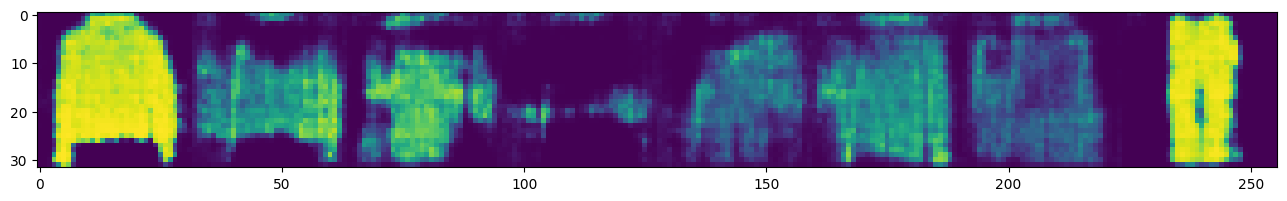

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/10] [D loss: 0.2464] [G loss: 3.1443]


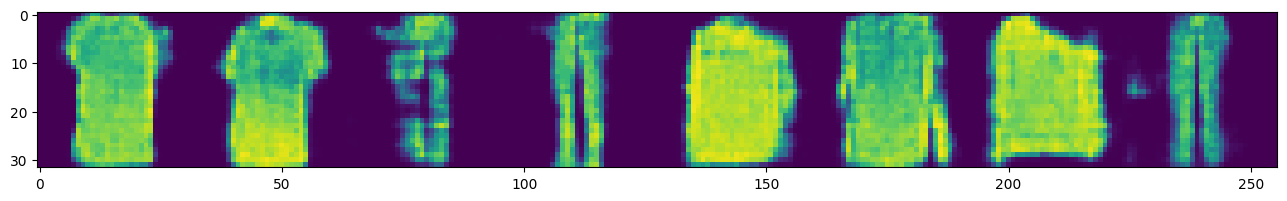

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/10] [D loss: 0.2786] [G loss: 2.9697]


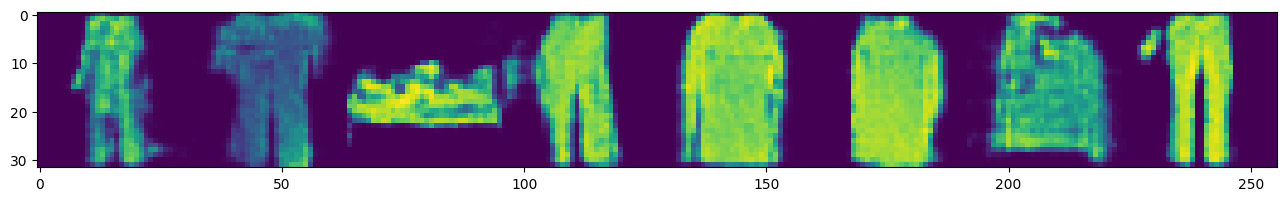

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/10] [D loss: 0.2399] [G loss: 3.2060]


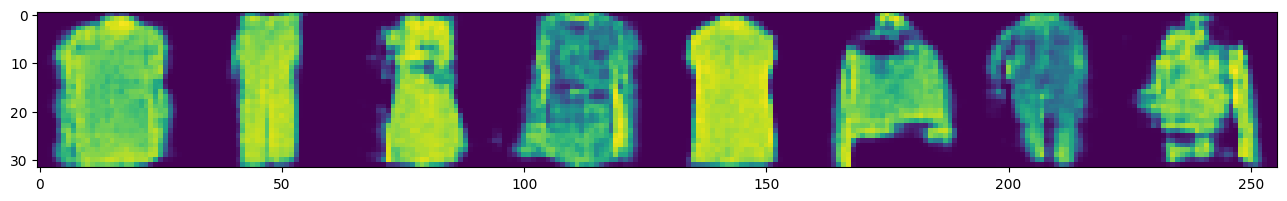

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/10] [D loss: 0.1421] [G loss: 3.8659]


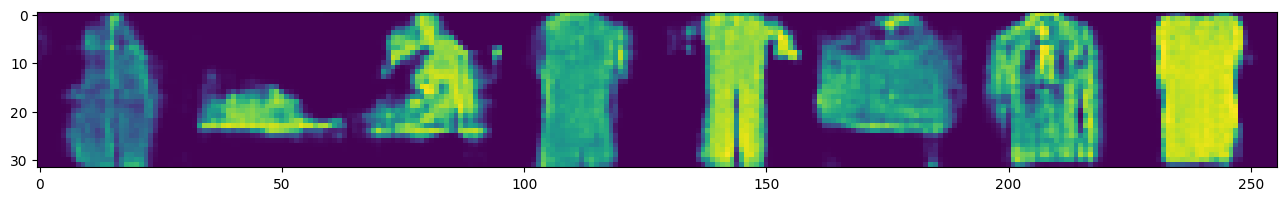

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/10] [D loss: 0.0733] [G loss: 4.8073]


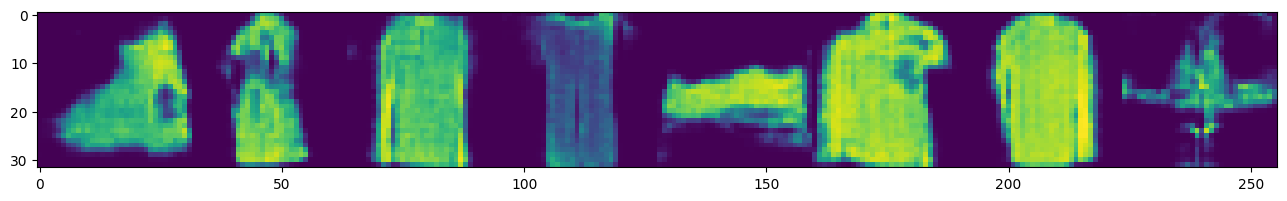

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/10] [D loss: 0.0522] [G loss: 5.4445]


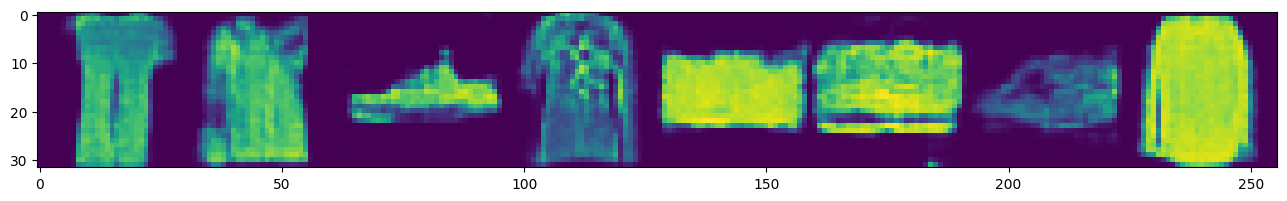

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/10] [D loss: 0.0454] [G loss: 5.8657]


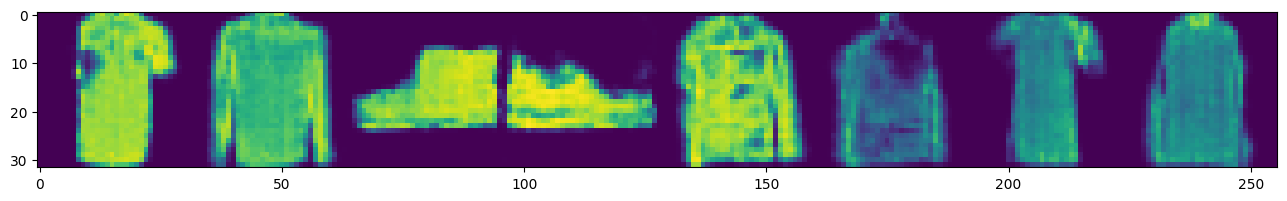

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/10] [D loss: 0.0450] [G loss: 5.9944]


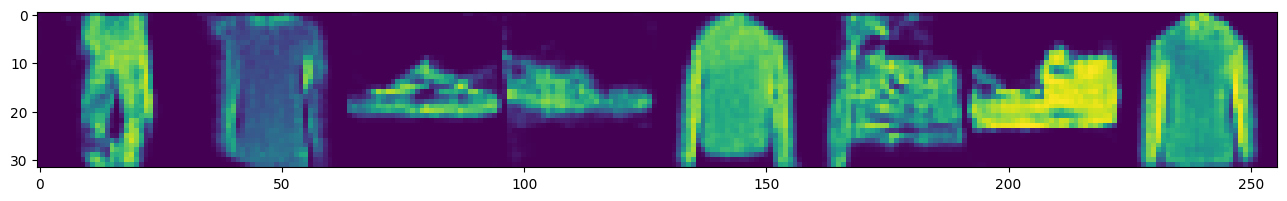

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/10] [D loss: 0.0392] [G loss: 6.1914]


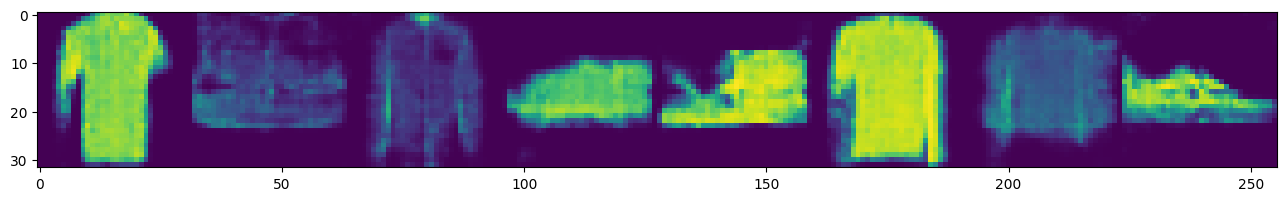

In [ ]:
gan = GANManager()
gan_history = gan.train(dataloader)

## Conditional GAN
To generate images corresponding to a specific class using a Generative Adversarial Network (GAN), we need to incorporate class information into the generation process. This approach is commonly known as a Conditional GAN (cGAN). Unlike standard GANs that generate images solely based on random noise, cGANs condition both the Generator and Discriminator on additional information, such as class labels.

### Conditional GAN Implementation

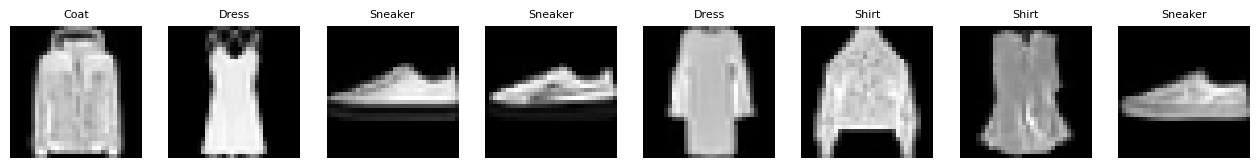

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = 32
C_IN = 1
LR = 2e-4
EPOCHS = 5
Z_DIM = 100
NUM_CLASSES = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if DEVICE == 'cuda' else torch.FloatTensor

CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)
    data = torchvision.datasets.FashionMNIST(
        root=".",
        download=True,
        train=True,
        transform=data_transform
    )
    return data

def plot_images(images, titles=None, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    num_images = len(images)
    for idx, img in enumerate(images):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img.squeeze().cpu(), cmap='gray')
        plt.axis('off')
        if titles:
            plt.title(titles[idx], fontsize=8)
    plt.show()

data = load_transformed_dataset()
dataloader = DataLoader(
    data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

batch_x, batch_y = next(iter(dataloader))
sample_images = batch_x[:8]
plot_images(sample_images, titles=[CLASS_NAMES[y] for y in batch_y[:8]])

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, num_classes=10, feature_g=64):
        super(ConditionalGenerator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.project = nn.Sequential(
            nn.Linear(z_dim + num_classes, feature_g * 4 * 4 * 4),
            nn.BatchNorm1d(feature_g * 4 * 4 * 4),
            nn.ReLU(True)
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), dim=1)
        x = self.project(gen_input)
        x = x.view(-1, 256, 4, 4)  # Assuming feature_g=64 -> 64*4=256
        img = self.net(x)
        return img

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_channels=1, num_classes=10, feature_d=64):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, feature_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(-1, -1, img.size(2), img.size(3))
        d_input = torch.cat([img, label_embedding], dim=1)
        real_or_fake = self.net(d_input)
        return real_or_fake.view(-1, 1).squeeze(1)


In [ ]:
class ConditionalGANManager():
    def __init__(self, z_dim=100, img_channels=1, num_classes=10, feature_g=64, feature_d=64, lr=2e-4, device='cpu'):
        self.device = device
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.generator = ConditionalGenerator(
            z_dim=z_dim,
            img_channels=img_channels,
            num_classes=num_classes,
            feature_g=feature_g
        ).to(device)

        self.discriminator = ConditionalDiscriminator(
            img_channels=img_channels,
            num_classes=num_classes,
            feature_d=feature_d
        ).to(device)
        self.optimizer_G = optim.Adam(
            self.generator.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )

        self.optimizer_D = optim.Adam(
            self.discriminator.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )
        self.criterion = nn.BCELoss()

    def train(self, dataloader, epochs=50):
        history = {'g_loss': [], 'd_loss': []}
        for epoch in range(epochs):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, batch_y) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
                batch_size = batch_x.size(0)
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                real_labels = torch.ones(batch_size, device=self.device)
                fake_labels = torch.zeros(batch_size, device=self.device)
                self.discriminator.zero_grad()
                outputs_real = self.discriminator(batch_x, batch_y)
                d_loss_real = self.criterion(outputs_real, real_labels)
                z = torch.randn(batch_size, self.z_dim, device=self.device)
                fake_images = self.generator(z, batch_y)
                outputs_fake = self.discriminator(fake_images.detach(), batch_y)
                d_loss_fake = self.criterion(outputs_fake, fake_labels)
                discriminator_loss = d_loss_real + d_loss_fake
                discriminator_loss.backward()
                self.optimizer_D.step()
                self.generator.zero_grad()
                z = torch.randn(batch_size, self.z_dim, device=self.device)
                fake_images = self.generator(z, batch_y)
                outputs = self.discriminator(fake_images, batch_y)
                generator_loss = self.criterion(outputs, real_labels)
                generator_loss.backward()
                self.optimizer_G.step()
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())

            mean_g_loss = np.mean(total_g_loss)
            mean_d_loss = np.mean(total_d_loss)
            history['g_loss'].append(mean_g_loss)
            history['d_loss'].append(mean_d_loss)

            print(
                f"[Epoch: {epoch+1}/{epochs}] [D loss: {mean_d_loss:.4f}] [G loss: {mean_g_loss:.4f}]"
            )

            if (epoch + 1) % 10 == 0 or epoch == 0:
                self.sample(n=8, class_label=None, plot=True)

        return history

    def sample(self, n, plot=True):
        with torch.no_grad():
            x = torch.randn((n, C_IN, IMG_SIZE, IMG_SIZE), device=DEVICE)
            xs = []

            for t in reversed(range(self.T)):
                t_tensor = torch.full((n,), t, device=DEVICE, dtype=torch.long)

                alpha_bar_t = self.alpha_bars[t_tensor].view(-1, 1, 1, 1)
                alpha_bar_t_prev = (
                    self.alpha_bars[t_tensor - 1].view(-1, 1, 1, 1)
                    if t > 0 else torch.tensor(1.0, device=DEVICE).view(-1, 1, 1, 1)
                )

                pred_noise = self.unet(x, t_tensor)

                x = (x - (1 - alpha_bar_t).sqrt() * pred_noise) / alpha_bar_t.sqrt()
                if t > 0:
                    noise = torch.randn_like(x)
                    x = x * alpha_bar_t_prev.sqrt() + noise * (1 - alpha_bar_t_prev).sqrt()

                if t % (self.T // 10) == 0 or t == 0:
                    xs.append(x.clone())

            final_image = x.clone()
            final_image = (final_image - final_image.min()) / (final_image.max() - final_image.min() + 1e-5)
            final_image = final_image.cpu().squeeze(0).numpy()

            if plot:
                self.plot_images(xs)

            return final_image


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?it/s]

[Epoch: 1/5] [D loss: 0.8380] [G loss: 1.8225]


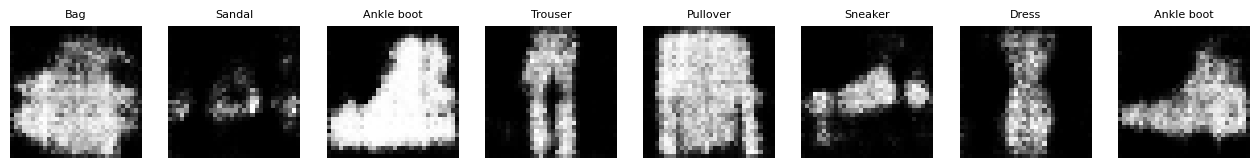

Epoch 2/5:   0%|          | 0/468 [00:00<?, ?it/s]

[Epoch: 2/5] [D loss: 0.9774] [G loss: 1.3576]


Epoch 3/5:   0%|          | 0/468 [00:00<?, ?it/s]

[Epoch: 3/5] [D loss: 1.0252] [G loss: 1.2709]


Epoch 4/5:   0%|          | 0/468 [00:00<?, ?it/s]

[Epoch: 4/5] [D loss: 0.9897] [G loss: 1.3600]


Epoch 5/5:   0%|          | 0/468 [00:00<?, ?it/s]

[Epoch: 5/5] [D loss: 0.7744] [G loss: 1.9315]


In [ ]:
conditional_gan = ConditionalGANManager(
    z_dim=Z_DIM,
    img_channels=C_IN,
    num_classes=NUM_CLASSES,
    feature_g=64,
    feature_d=64,
    lr=LR,
    device=DEVICE
)

cgan_history = conditional_gan.train(dataloader, epochs=EPOCHS)


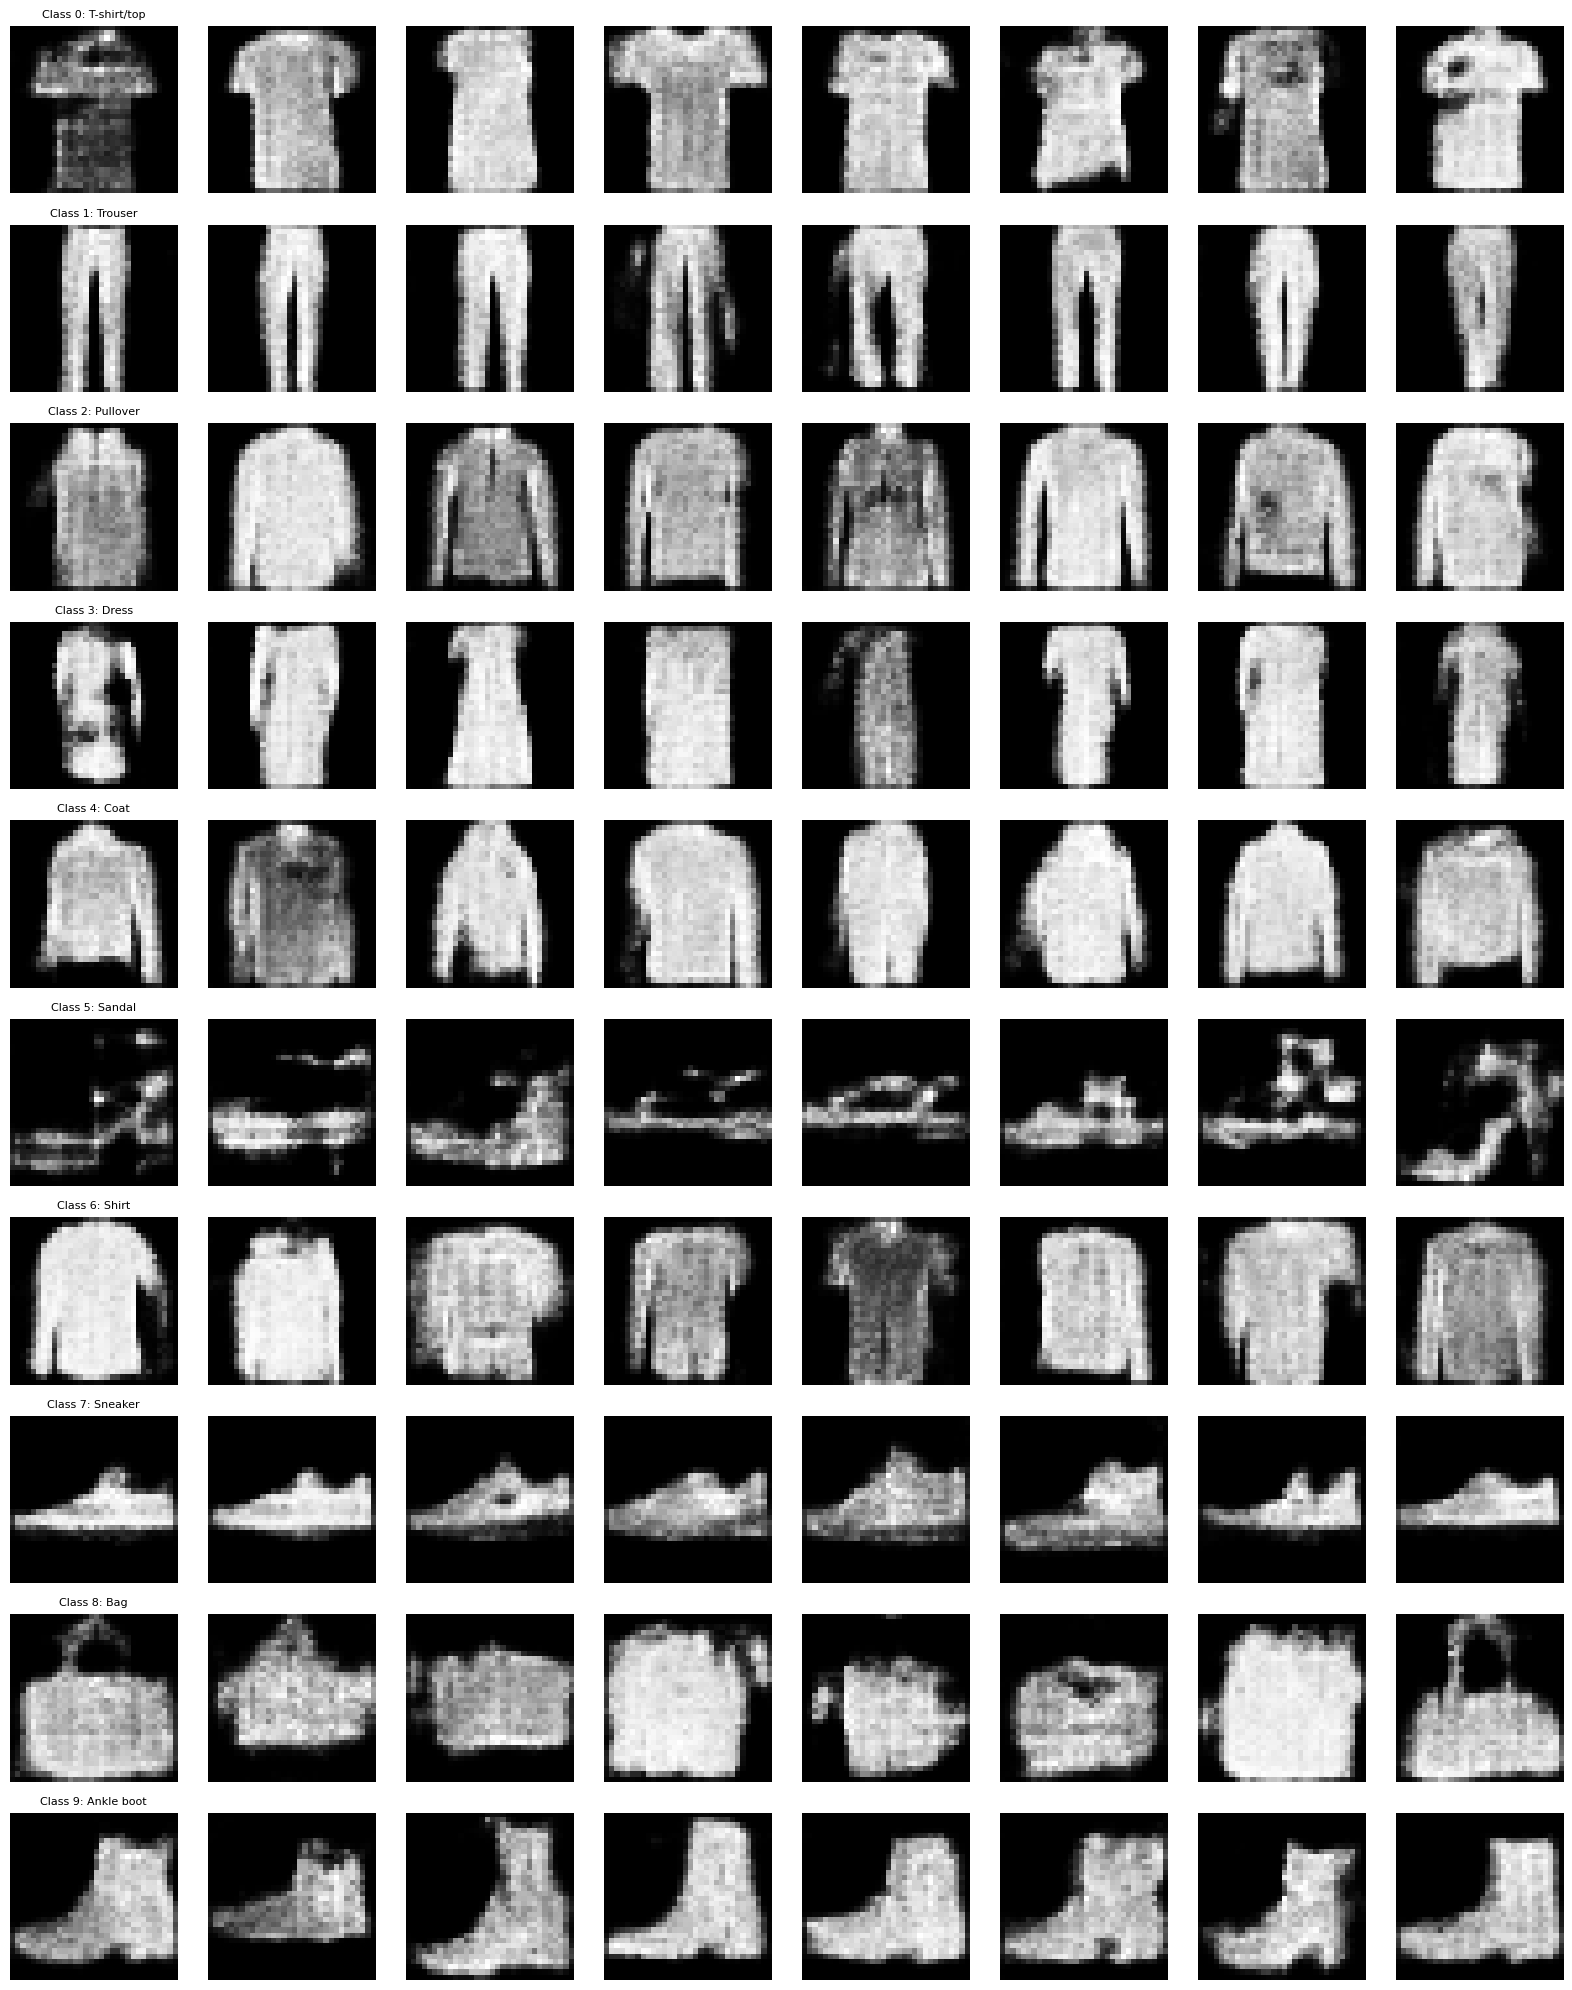

In [ ]:
IMAGES_PER_CLASS = 8
all_generated_images = []

for class_label in range(NUM_CLASSES):
    gen_imgs = conditional_gan.sample(
        n=IMAGES_PER_CLASS,
        class_label=class_label,
        plot=False
    )
    all_generated_images.append(gen_imgs)

def plot_class_specific_images(generated_images, images_per_class, num_classes):
    plt.figure(figsize=(images_per_class * 2, num_classes * 2))
    for class_idx, class_imgs in enumerate(generated_images):
        for img_idx in range(images_per_class):
            plt_idx = class_idx * images_per_class + img_idx + 1
            plt.subplot(num_classes, images_per_class, plt_idx)
            plt.imshow(class_imgs[img_idx].squeeze().cpu(), cmap='gray')
            plt.axis('off')
            if img_idx == 0:
                class_name = CLASS_NAMES[class_idx]
                plt.title(f"Class {class_idx}: {class_name}", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_class_specific_images(
    generated_images=all_generated_images,
    images_per_class=IMAGES_PER_CLASS,
    num_classes=NUM_CLASSES
)


## DDPM

Denoising diffusion probabilistic models (DDPMs) generate images by iteratively denoising a completely random pattern in a step-by-step process. These models learn two key components: a set of diffusion steps that define how noise evolves over time, and a denoising function that progressively removes noise at each step.

The denoising function is typically implemented as a neural network. This network takes the noisy data and the corresponding time step as inputs and produces the denoised data as output. Through multiple denoising iterations across time steps, the model ultimately generates an image that resembles those in the training distribution.

The overall procedure for training and sampling in DDPMs is concisely outlined in the pseudocode provided in the [DDPM Paper](https://arxiv.org/pdf/2006.11239).

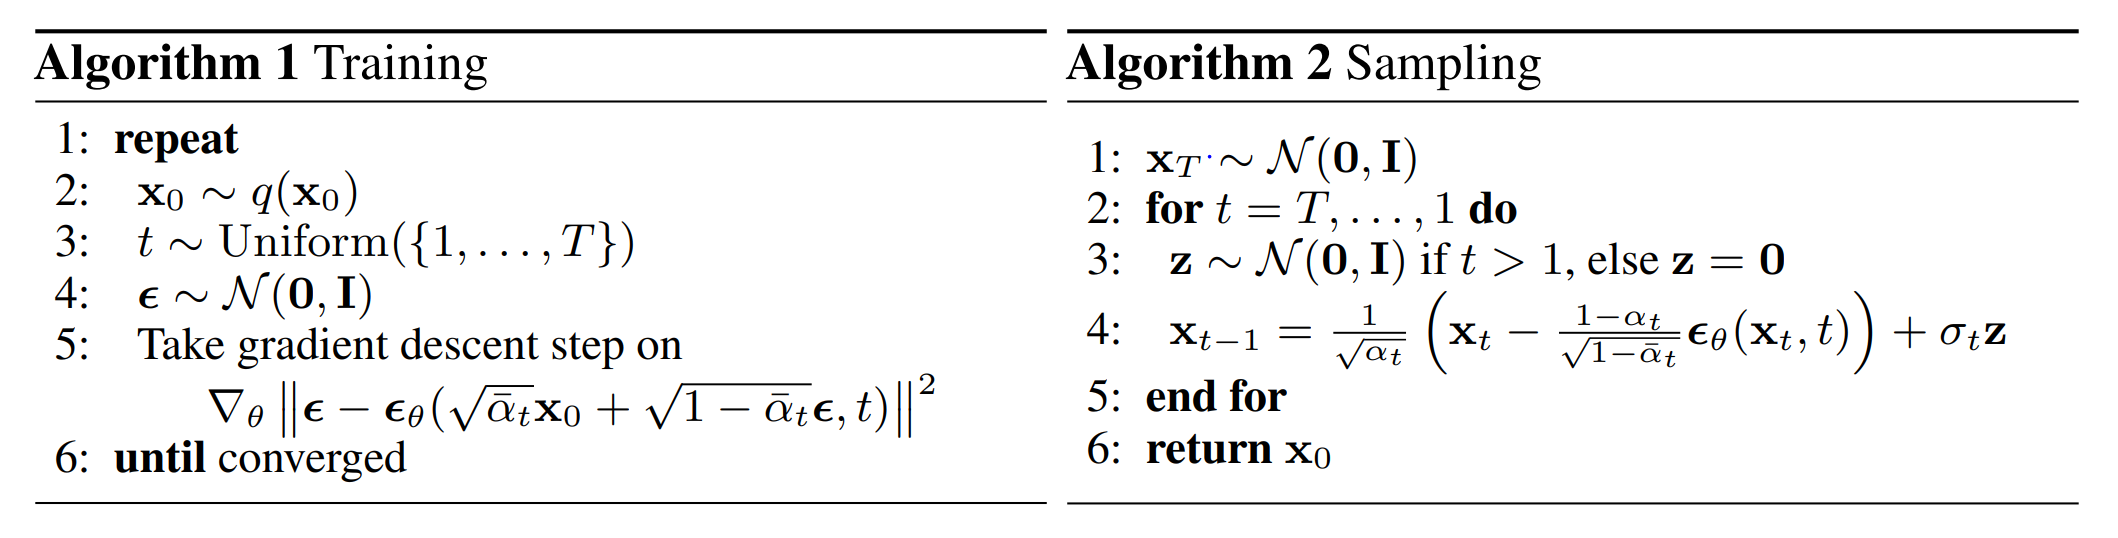

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. We can use this module in Down/Up blocks. Also, by removing the residual connection, we can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. We can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

Structure for UNet:

+ Convolutional block
+ Down block
+ Attention
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

In [3]:
class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_residuals=2):
        super(ConvResNet, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm = nn.GroupNorm(1, out_channels)
        self.residuals = nn.Sequential(
            *[nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                            nn.GroupNorm(1, out_channels), nn.ReLU(inplace=True)) for _ in range(num_residuals)]
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return x + self.residuals(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1),
            nn.GroupNorm(1, in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1),
            nn.GroupNorm(1, in_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(1, out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip, t):
        x = self.up(x)
        return torch.cat((x, skip), axis=1)

class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.attn = nn.MultiheadAttention(in_channels, num_heads=8)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x_reshaped = x.view(batch_size, channels, -1).permute(2, 0, 1)
        attn_out, _ = self.attn(x_reshaped, x_reshaped, x_reshaped)
        attn_out = attn_out.permute(1, 2, 0).view(batch_size, channels, height, width)
        return x + attn_out


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = ConvResNet(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.attn = Attention(512)
        self.up1 = Up(512, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.outc = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        x4 = self.attn(x4)
        x = self.up1(x4, x3, t)
        x = self.up2(x, x2, t)
        x = self.up3(x, x1, t)
        return self.outc(x)

In [6]:
class DDPMManager():
    def __init__(self):
        self.T = 1000
        self.beta_start = 1e-4
        self.beta_end = 0.02

        self.unet = UNet().to(DEVICE)
        self.optimizer = optim.Adam(self.unet.parameters(), lr=LR)

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.T).to(DEVICE)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(DEVICE)

    def train(self, dataloader, **kwargs):
        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                t = torch.randint(0, self.T, (batch_x.size(0),), device=DEVICE).long()
                alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
                noise = torch.randn_like(batch_x)
                noisy_images = torch.sqrt(alpha_bar_t) * batch_x + torch.sqrt(1 - alpha_bar_t) * noise
                noise_pred = self.unet(noisy_images, t)
                loss = F.mse_loss(noise_pred, noise)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {mean_loss:.4f}")
            history['loss'].append(mean_loss)

        return history

    def sample(self, n, plot=True):
        with torch.no_grad():
            x = torch.randn((n, C_IN, IMG_SIZE, IMG_SIZE), device=DEVICE)
            xs = []

            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t], device=DEVICE).long()
                alpha_bar_t = self.alpha_bars[t_tensor].view(-1, 1, 1, 1)
                alpha_bar_t_prev = self.alpha_bars[t_tensor - 1].view(-1, 1, 1, 1) if t > 0 else torch.tensor(1.0, device=DEVICE).view(-1, 1, 1, 1)

                pred_noise = self.unet(x, t_tensor)
                x = (x - (1 - alpha_bar_t).sqrt() * pred_noise) / alpha_bar_t.sqrt()
                if t > 0:
                    x = x * alpha_bar_t_prev.sqrt() + torch.randn_like(x) * (1 - alpha_bar_t_prev).sqrt()

                if t % (self.T // 10) == 0 or t == 0:
                    xs.append(x.clone())

            if plot:
                plot_images(xs[0])
            return x

In [ ]:
ddpm = DDPMManager()
ddpm_history = ddpm.train(dataloader)

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.0690


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.0420


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.0373


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.0344


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.0330


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.0319


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.0314


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.0305


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.0303


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.0296


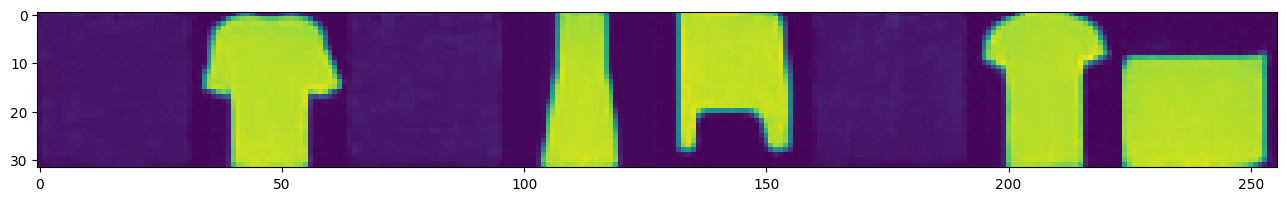

In [ ]:
n_samples = 8
generated_samples = ddpm.sample(n=n_samples, plot=False)
plot_images(generated_samples[:8])

### ❓ **Question 3**
- *(6 points)* How can we generate images from a specific target class in DDPM?
- *(Bonus - 25 points)* Implement your idea and plot one trajectory of denoised images per class.


### Conditional DDPM
To generate images from a specific target class in DDPM, we need to condition the model on the class label during both training and sampling. This is typically done by incorporating the class label into the model's input or by using a conditional mechanism such as class embeddings. Here's how we can achieve this:

1. Modify the UNet to Accept Class Labels: We need to modify the UNet architecture to accept class labels as an additional input. This can be done by embedding the class labels and adding them to the feature maps at each level of the UNet.

2. Conditional Training: During training, we pass the class label along with the noisy image and timestep to the UNet. The model learns to denoise the image while being aware of the class label.

3. Conditional Sampling: During sampling, we pass the desired class label to the UNet to generate images from that specific class.

In [4]:
class ConditionalUNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalUNet, self).__init__()
        self.num_classes = num_classes
        self.inc = ConvResNet(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.attn = Attention(512)
        self.up1 = Up(512, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.outc = nn.Conv2d(128, 1, kernel_size=1)

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 512)

    def forward(self, x, t, class_labels):
        # Embed class labels
        class_emb = self.class_embedding(class_labels).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        x4 = self.attn(x4)

        # Add class embedding to the feature maps
        x4 = x4 + class_emb

        x = self.up1(x4, x3, t)
        x = self.up2(x, x2, t)
        x = self.up3(x, x1, t)
        return self.outc(x)

In [21]:
class ConditionalDDPMManager(DDPMManager):
    def __init__(self, num_classes=10):
        super(ConditionalDDPMManager, self).__init__()
        self.unet = ConditionalUNet(num_classes).to(DEVICE)
        self.optimizer = optim.Adam(self.unet.parameters(), lr=LR)

    def train(self, dataloader, **kwargs):
        history = dict(loss=[])
        for epoch in range(30):
            total_loss = []
            for i, (batch_x, batch_y) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                batch_y = batch_y.to(DEVICE)

                t = torch.randint(0, self.T, (batch_x.size(0),), device=DEVICE).long()
                alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
                noise = torch.randn_like(batch_x)
                noisy_images = torch.sqrt(alpha_bar_t) * batch_x + torch.sqrt(1 - alpha_bar_t) * noise
                noise_pred = self.unet(noisy_images, t, batch_y)
                loss = F.mse_loss(noise_pred, noise)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {mean_loss:.4f}")
            history['loss'].append(mean_loss)

        return history

    def sample(self, n, class_label, plot=True):
        with torch.no_grad():
            x = torch.randn((n, C_IN, IMG_SIZE, IMG_SIZE), device=DEVICE)
            class_labels = torch.tensor([class_label] * n, device=DEVICE)
            xs = []

            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t], device=DEVICE).long()
                alpha_bar_t = self.alpha_bars[t_tensor].view(-1, 1, 1, 1)
                alpha_bar_t_prev = self.alpha_bars[t_tensor - 1].view(-1, 1, 1, 1) if t > 0 else torch.tensor(1.0, device=DEVICE).view(-1, 1, 1, 1)

                pred_noise = self.unet(x, t_tensor, class_labels)
                x = (x - (1 - alpha_bar_t).sqrt() * pred_noise) / alpha_bar_t.sqrt()
                if t > 0:
                    x = x * alpha_bar_t_prev.sqrt() + torch.randn_like(x) * (1 - alpha_bar_t_prev).sqrt()

                if t % (self.T // 10) == 0 or t == 0:
                    xs.append(x.clone())

            if plot:
                plot_images(xs[0])
            return x
    def sample_trajectory(self, n, class_label):
        with torch.no_grad():
            x = torch.randn((n, C_IN, IMG_SIZE, IMG_SIZE), device=DEVICE)
            class_labels = torch.tensor([class_label] * n, device=DEVICE)
            xs = []

            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t], device=DEVICE).long()
                alpha_bar_t = self.alpha_bars[t_tensor].view(-1, 1, 1, 1)
                alpha_bar_t_prev = self.alpha_bars[t_tensor - 1].view(-1, 1, 1, 1) if t > 0 else torch.tensor(1.0, device=DEVICE).view(-1, 1, 1, 1)

                pred_noise = self.unet(x, t_tensor, class_labels)
                x = (x - (1 - alpha_bar_t).sqrt() * pred_noise) / alpha_bar_t.sqrt()
                if t > 0:
                    x = x * alpha_bar_t_prev.sqrt() + torch.randn_like(x) * (1 - alpha_bar_t_prev).sqrt()

                if t % (self.T // 10) == 0 or t == 0:
                    xs.append(x.clone())

            return xs


In [22]:
conditional_ddpm = ConditionalDDPMManager(num_classes=10)
cddpm_history = conditional_ddpm.train(dataloader)

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.0701


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.0402


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.0358


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.0333


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.0328


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.0313


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.0304


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.0300


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.0299


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.0291


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 11/10 | Loss: 0.0289


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 12/10 | Loss: 0.0284


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 13/10 | Loss: 0.0286


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 14/10 | Loss: 0.0279


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 15/10 | Loss: 0.0278


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 16/10 | Loss: 0.0277


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 17/10 | Loss: 0.0276


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 18/10 | Loss: 0.0273


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 19/10 | Loss: 0.0269


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 20/10 | Loss: 0.0271


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 21/10 | Loss: 0.0267


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 22/10 | Loss: 0.0267


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 23/10 | Loss: 0.0268


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 24/10 | Loss: 0.0262


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 25/10 | Loss: 0.0270


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 26/10 | Loss: 0.0267


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 27/10 | Loss: 0.0263


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 28/10 | Loss: 0.0258


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 29/10 | Loss: 0.0260


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 30/10 | Loss: 0.0260


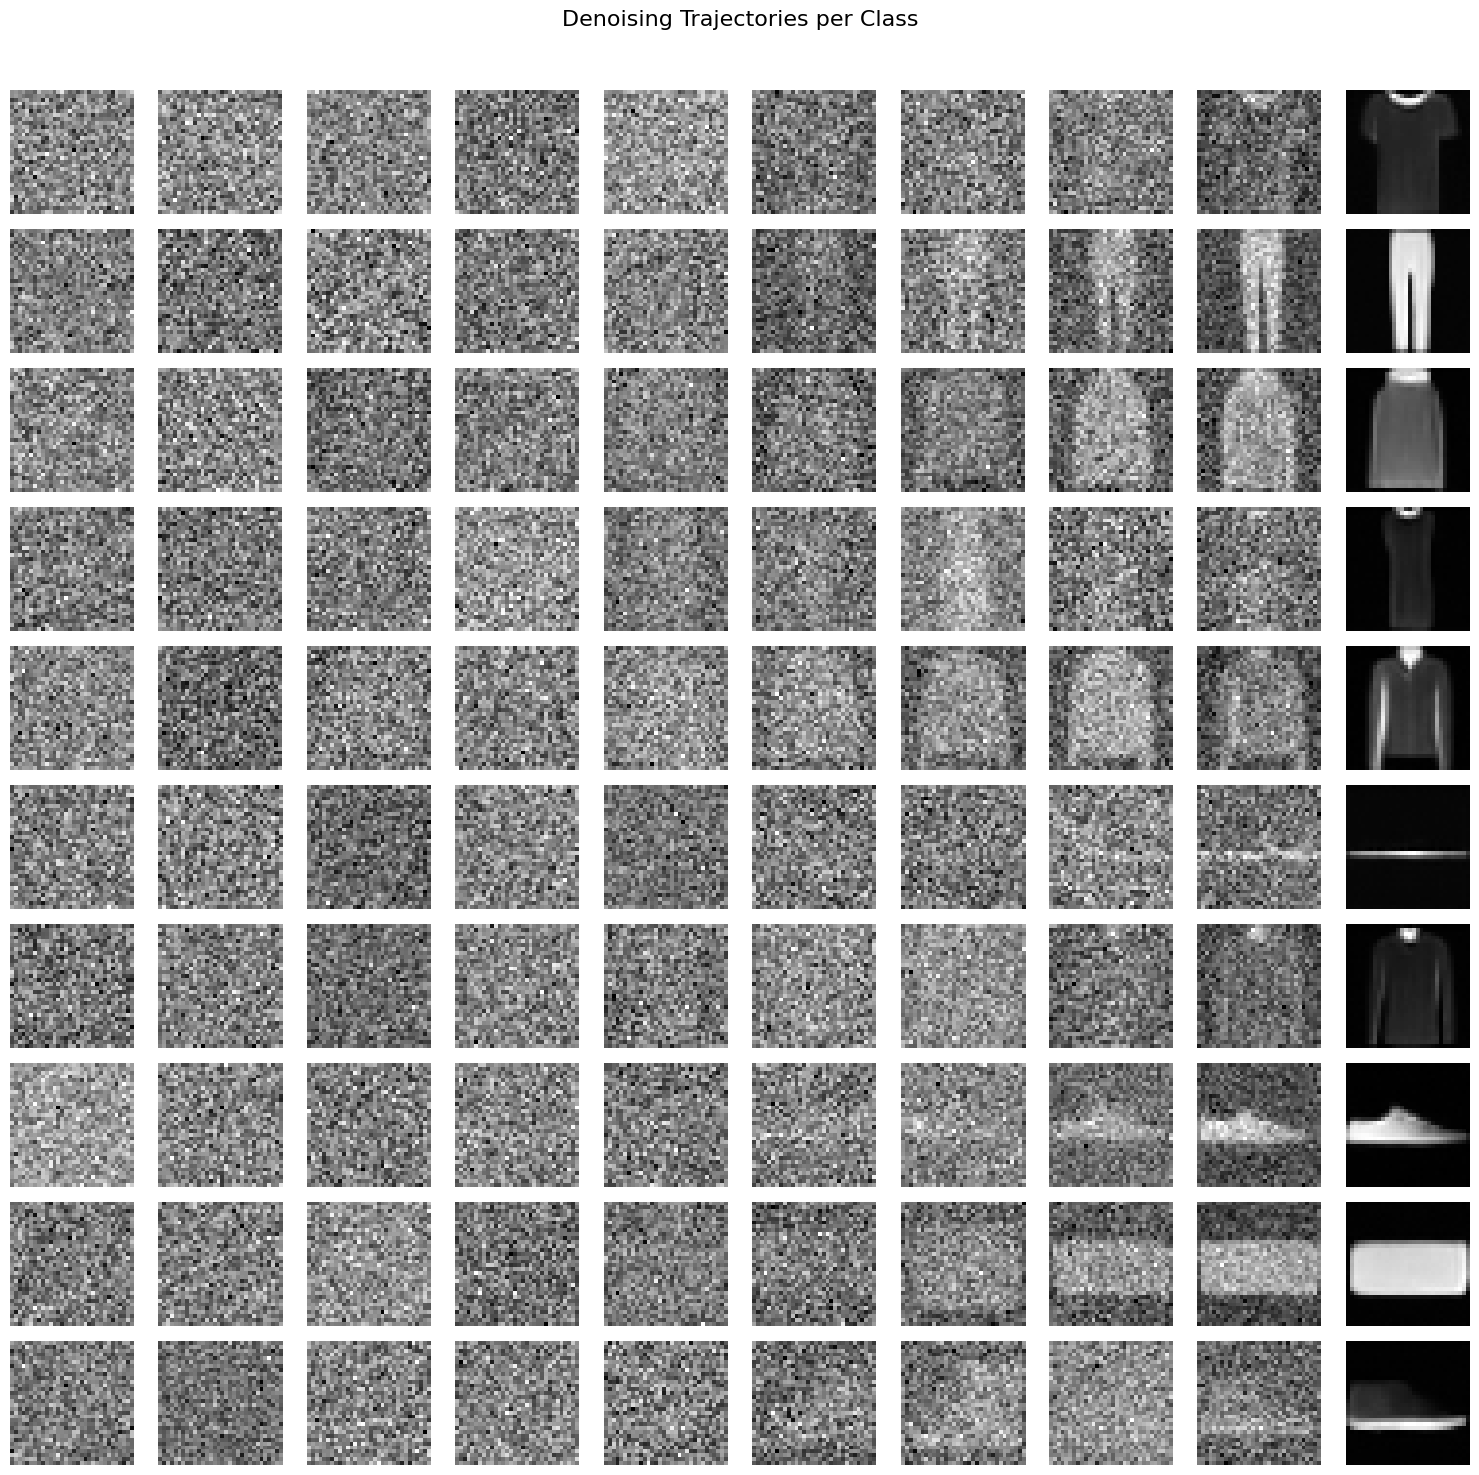

In [23]:
def plot_trajectories_per_class(conditional_ddpm, num_classes, img_size=28):
    # Create a figure for plotting
    fig, axes = plt.subplots(num_classes, 10, figsize=(15, num_classes * 1.5))
    fig.suptitle("Denoising Trajectories per Class", fontsize=16)

    for class_label in range(num_classes):
        # Get the denoising trajectory for the current class
        trajectories = conditional_ddpm.sample_trajectory(1, class_label)

        # Plot the trajectory
        for step_idx, img in enumerate(trajectories):
            # Normalize the image to [0, 1] range
            img_np = (img.squeeze().cpu().numpy() + 1) / 2
            axes[class_label, step_idx].imshow(img_np, cmap="gray")
            axes[class_label, step_idx].axis("off")

        # Add a label for each row
        axes[class_label, 0].set_ylabel(f"Class {class_label}", rotation=0, labelpad=20, fontsize=12, va="center")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot trajectories for all classes
plot_trajectories_per_class(conditional_ddpm, num_classes=10)

## Comparisons

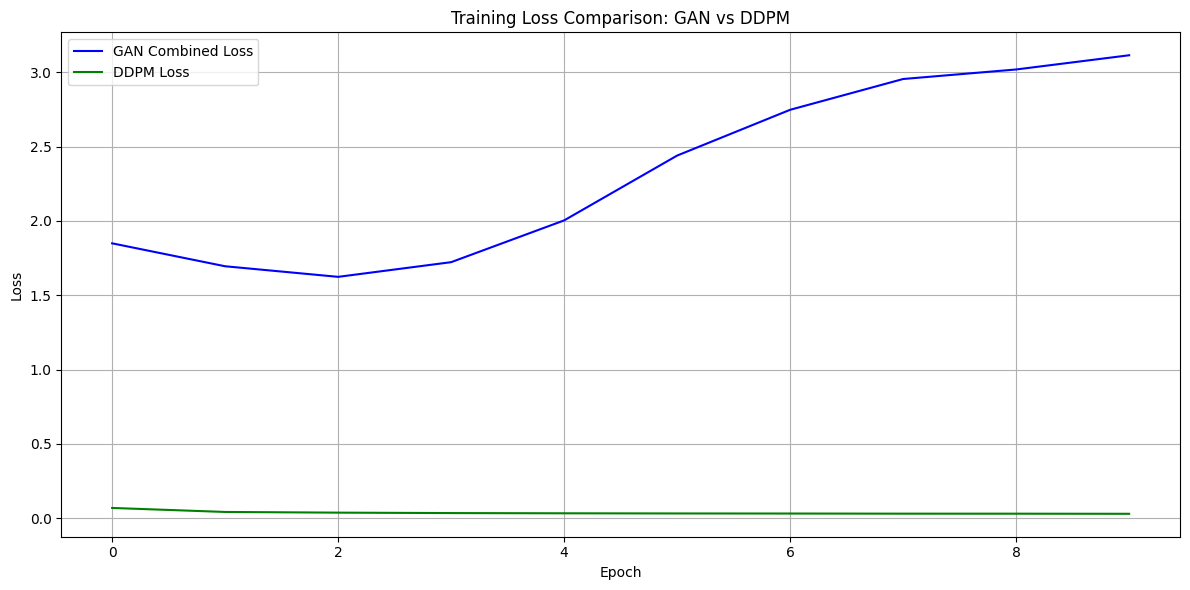

In [ ]:
# Combine GAN losses (e.g., average of generator and discriminator losses)
gan_combined_loss = [
    (g_loss + d_loss) / 2
    for g_loss, d_loss in zip(gan_history["g_loss"], gan_history["d_loss"])
]

# Plot Loss Curves
plt.figure(figsize=(12, 6))

# Plot combined GAN loss
plt.plot(gan_combined_loss, label="GAN Combined Loss", color="blue")

# Plot DDPM loss
plt.plot(ddpm_history["loss"], label="DDPM Loss", color="green")

# Formatting
plt.title("Training Loss Comparison: GAN vs DDPM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


### Sample Images of GAN:
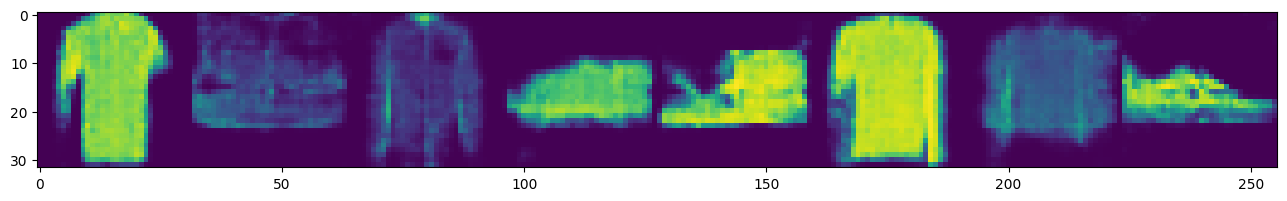


### Sample images of DDPM:
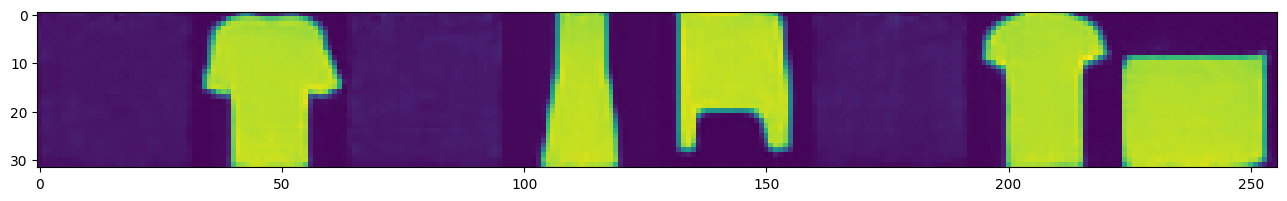


### GAN vs DDPM:
- **Loss Trends**

    The training loss curves for both models reveal distinct optimization behaviors:\
    **GAN:**  
    Initially, the loss decreases, showing learning progress, but it increases as training continues. This instability reflects typical challenges in GAN training, such as mode collapse and adversarial instability. Oscillations in the loss indicate difficulties in maintaining a balance between the generator and discriminator, which affects the final output quality.\
    **DDPM:**  
    The loss remains consistently low and stable throughout training, showcasing the smoother and more reliable optimization of the diffusion model. This stability translates into more coherent results with fewer artifacts in the generated images.

- **Visual Quality of Generated Samples**

    **GAN:**  
    The outputs are noisy and lack structure, with evident artifacts and incomplete forms. While some samples hint at the correct shape, many are distorted or blurry, showcasing the impact of instability in adversarial training.\
    **DDPM:**  
    The generated images are smoother and exhibit better-defined contours for simpler objects. Although the results lack fine details and appear overly smoothed in some cases, the overall quality is better and more reliable than GAN outputs.

- **Key Observations**

    **Stability:**  
    GAN training is prone to instability due to adversarial optimization, as reflected in the increasing loss curve and poor sample quality. DDPM provides a robust and stable training process, consistently producing coherent samples.\
    **Detail vs. Structure:**  
    GAN samples occasionally show fine details but struggle with overall coherence and structure. DDPM samples prioritize structural integrity but may sacrifice fine-grained details due to the diffusion process.\
    **Artifacts:**  
    GAN samples suffer from visible artifacts and incomplete patterns. DDPM samples are cleaner, with smoother transitions and fewer distortions.
